In [2]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
# # Objective function (can be modified for different problems)
# def objective_function(position):
#     # Example: Rastrigin function (a common multimodal benchmark function)
#     return 10 * len(position) + sum([x**2 - 10 * np.cos(2 * np.pi * x) for x in position])

In [ ]:
# # two target objective_function
# def objective_function(x, y):
#     "Objective function"
#     return ((x/100)-3.14)**2 + ((y/100)-2.72)**2 + np.sin(3*(x/100)+1.41) + np.sin(4*(y/100)-1.73)

In [3]:
# Objective function (can be modified for different problems)
def objective_function(position):
    # Ensure the function works only for 2D input
    if len(position) != 2:
        raise ValueError("Himmelblau's function is defined for 2D inputs only.")
    x, y = position
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

In [4]:
# Initialization
# GSO Parameters
num_glowworms = 50       # Number of glowworms
dimension = 2            # Problem dimensionality
lower_bound = -500         # Lower bound of the search space
upper_bound = 500          # Upper bound of the search space
iterations = 500         # Number of iterations
luciferin_decay = 0.2    # Decay rate of luciferin
luciferin_enhancement = 0.8 # Enhancement of luciferin after each iteration
neighborhood_radius = 2  # Initial neighborhood radius
step_size = 0.03         # Movement step size

# Initialize glowworm positions and luciferin levels
np.random.seed(57)
glowworms = np.random.uniform(lower_bound, upper_bound, (num_glowworms, dimension))
luciferin = np.zeros(num_glowworms)

In [8]:
np.sin(3*np.pi/2)

-1.0

In [ ]:
class glowworm:
    def __init__(self, env, ID, glowworms, X=np.array([1, 1]), waypoint = np.array([250,250]), luciferin_decay=0.2, luciferin_enhancement=0.8, 
                 speed=1.5433, transRange=100.0, max_hop=5):
        self.env = env
        self.ID = ID
        self.glowworms = glowworms  # List of all glowworms
        ### luciferin Parameters
        self.luciferin_decay = luciferin_decay    # Decay rate of luciferin
        self.luciferin_enhancement = luciferin_enhancement # Enhancement of luciferin after each iteration
        self.luciferin = 0.0
 
        ### Communicaton Parameters
        self.transmission_range = transRange
        self.nMsg = [[self.ID,self.luciferin]] ###[[ID_A,L],[ID_B,,],[ID_C,,],...[ID_E,,]]
        self.max_hop = max_hop
        
        ### Mobility Parameters
        self.X = X
        self.V = np.random.randn(2) * 0.1
        self.speed = speed        
        self.waypoint = waypoint

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def broadcast(self):
        """Broadcast nbest to other glowworms based on proximity."""
        for glowworm in self.glowworms:
            if glowworm != self:
                distance = np.linalg.norm(self.X - glowworm.X) # Euclidean distance
                if distance < self.transmission_range:  # Accoustic module Transmission range
                    glowworm.receive(self.nMsg)

    def receive(self, nMsg):
        """update the personal nbest"""
        received_luciferin = nMsg[0][1]
        if self.luciferin < received_luciferin:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
        else:

    
    def update_luciferin(self):
        self.luciferin = (1 - self.luciferin_decay) * self.luciferin + self.luciferin_enhancement * (1 / (1 + objective_function(self.X)))

    def sensing(self):
        self.update_luciferin()

        if fitness < self.pbest_fitness:
            self.pbest_position = self.X.copy()
            self.pbest_fitness = fitness

        if fitness < self.nbest_fitness:
            self.nbest_position = self.X.copy()
            self.nbest_fitness = fitness

    def move(self):
        if not self.stop_flag:
            if self.targetFounded:
                direction = self.nbest_position-self.X
            else:
                direction = self.waypoint-self.X
            self.X = self.X + self.speed * (direction / np.linalg.norm(direction))
            distance = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
            if distance <= 3:  # Interaction threshold
                self.update()
                #print(self.name," Updated! ", self.V, " nbest_loc ", self.nbest_position, " nbest_fit ", self.nbest_fitness)

    # def targetFound(self):
    #     if np.linalg.norm(self.X - self.target[0]) <= 1:
    #         self.stop_flag = True
    #         self.targetFounded = True
    #         self.nbest_position = self.target[0].copy()
    #         self.nbest_fitness = self.target[1]

    def run(self):
        i = 0
        while True:
            # self.targetFound()
            self.sensing()
            self.move()
            if i%5 ==0:
                self.broadcast()  # broadcast nbest to neighbors
            if i%10 ==0:    
                self.positions.append(self.X.copy()) # take the records of position
            i = i + 1
            yield self.env.timeout(1)

In [ ]:
def initialize_grid_glowworms(n_glowworms, start, end):
    """Evenly distribute glowworms on a grid within the search space."""
    list_glowworms = []
    
    # Determine the number of rows and columns based on the number of glowworms
    n_side = int(np.ceil(np.sqrt(n_glowworms)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create glowworms and assign grid positions
    for i in range(n_glowworms):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_glowworms.append(grid_position)
    
    return list_glowworms

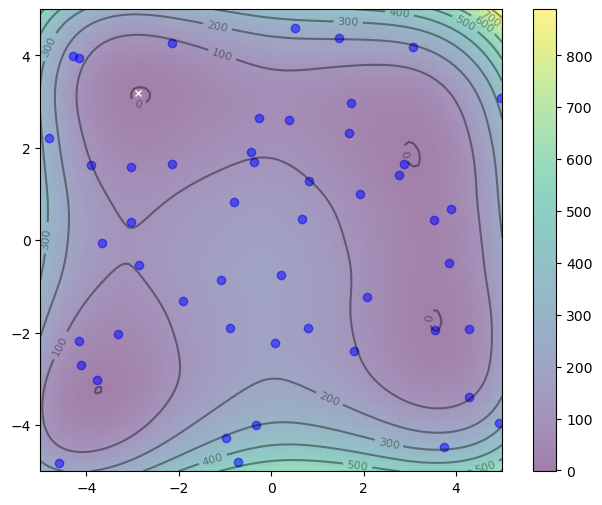

In [39]:
# Plotting the objective function and Glowworm before searching
x, y = np.array(np.meshgrid(np.linspace(lower_bound, upper_bound, 100), np.linspace(lower_bound, upper_bound, 100)))
z = objective_function([x, y])
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[lower_bound, upper_bound, lower_bound, upper_bound], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(glowworms[:,0], glowworms[:,1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([glowworms[best_idx][0]], [glowworms[best_idx][1]], marker='*', s=100, color='black', alpha=0.4)

In [40]:
positions = []
# Main GSO loop
for iteration in range(iterations):
    # Update luciferin levels based on objective function values
    for i in range(num_glowworms):
        luciferin[i] = (1 - luciferin_decay) * luciferin[i] + luciferin_enhancement * (1 / (1 + objective_function(glowworms[i])))

    # Move glowworms towards neighbors with higher luciferin
    for i in range(num_glowworms):
        # Find neighbors within the neighborhood radius with higher luciferin levels
        neighbors = []
        for j in range(num_glowworms):
            if i != j:
                distance = np.linalg.norm(glowworms[i] - glowworms[j])
                if distance < neighborhood_radius and luciferin[j] > luciferin[i]:
                    neighbors.append(j)

        # Move towards a randomly selected neighbor with higher luciferin
        if neighbors:
            #print("TRUE for worm "+str(i))
            #print("Old position " + str(glowworms[i]))
            chosen_neighbor = glowworms[np.random.choice(neighbors)]
            direction = (chosen_neighbor - glowworms[i])
            direction /= np.linalg.norm(direction)  # Normalize direction
            #print(direction)
            glowworms[i] += step_size * direction  # Move towards neighbor
            #print("New position " + str(glowworms[i]))

    # Optional: Update neighborhood radius (dynamic radius adjustment)
    neighborhood_radius = max(0.1, neighborhood_radius * 0.95)  # Reduce radius gradually

    # Output best solution found in this iteration
    best_idx = np.argmin([objective_function(g) for g in glowworms])
print(f"Iteration {iteration + 1}, Best Position: {glowworms[best_idx]}, Best Value: {objective_function(glowworms[best_idx])}")
    # print(glowworms)


Iteration 500, Best Position: [2.9863781  1.88245215], Best Value: -1.014357031588219


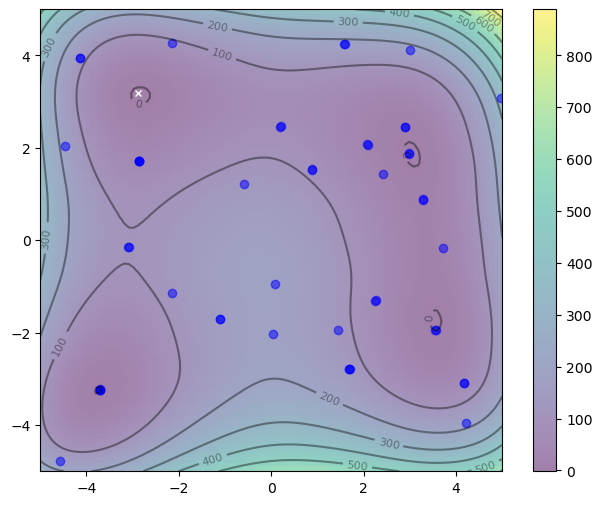

In [41]:
# Plotting the objective function and Glowworm after searching
x, y = np.array(np.meshgrid(np.linspace(lower_bound, upper_bound, 100), np.linspace(lower_bound, upper_bound, 100)))
z = objective_function([x, y])
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[lower_bound, upper_bound, lower_bound, upper_bound], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(glowworms[:,0], glowworms[:,1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([glowworms[best_idx][0]], [glowworms[best_idx][1]], marker='*', s=100, color='black', alpha=0.4)

In [36]:
# Final best position and value
best_idx = np.argmin([objective_function(g) for g in glowworms])
print("\nOptimal Position:", glowworms[best_idx])
print("Optimal Value:", objective_function(glowworms[best_idx]))



Optimal Position: [ 1.07826074 -0.91656087]
Optimal Value: 4.530612467798258


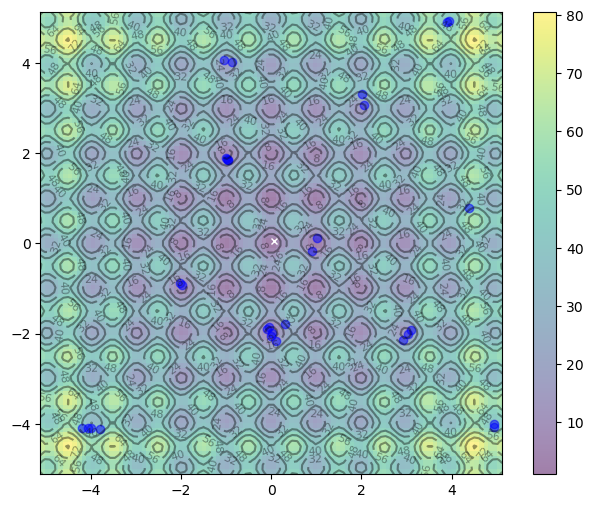

In [84]:
# Plotting the objective function
x, y = np.array(np.meshgrid(np.linspace(lower_bound, upper_bound, 100), np.linspace(lower_bound, upper_bound, 100)))
z = objective_function([x, y])
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[lower_bound, upper_bound, lower_bound, upper_bound], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][:,0], positions[0][:,1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([glowworms[best_idx][0]], [glowworms[best_idx][1]], marker='*', s=100, color='black', alpha=0.4)

In [42]:
len(positions)

20

In [70]:
positions[6][:,0], positions[6][:,1]

(array([ 3.14607711, -1.10396657,  3.03725121,  2.5814425 ,  2.99440419,
        -3.21256392, -4.09722727, -1.05451189,  2.39679462, -3.8435299 ,
         4.01472712,  4.46270553, -3.01026806, -0.82393027, -4.90928137,
         0.07661577,  3.35702984,  0.05520867,  3.00700964, -0.94595281,
        -2.7356894 , -0.17343721, -4.33032774,  0.32461136,  1.15216515,
         1.81958622,  2.85161478,  3.30216898,  2.80474811, -3.15184385]),
 array([ 0.93739475, -3.24223046,  0.67815876,  0.66631992,  1.02415131,
         3.89245221, -3.00818875,  1.97879374,  0.57200696, -2.88877582,
        -0.99858817,  5.00111114,  3.9604659 ,  2.04110578,  0.07418729,
        -1.07151324,  0.9085666 , -1.28386975,  0.82445615, -3.40691821,
         3.97954872, -1.14547997, -3.11790691, -1.43368646, -4.9435382 ,
         1.88934448,  0.94754077, -3.54478233,  0.79260848,  3.66513581]))

MovieWriter imagemagick unavailable; using Pillow instead.


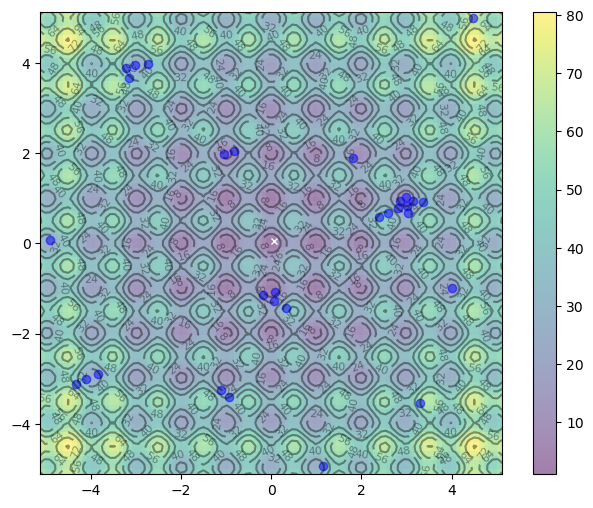

In [71]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(lower_bound, upper_bound, 100), np.linspace(lower_bound, upper_bound, 100)))
z = objective_function([x, y])
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[lower_bound, upper_bound, lower_bound, upper_bound], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
#p_plot = ax.scatter(positions[0][:,0], positions[0][:,1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([glowworms[best_idx][0]], [glowworms[best_idx][1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[lower_bound, upper_bound, lower_bound, upper_bound], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions[i]:
        p_plot = ax.scatter(pos[0], pos[1], marker='o', color='blue', alpha=0.5)
    #nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot

anim = FuncAnimation(fig, animate, frames=len(positions), interval=500, blit=False, repeat=True)
anim.save("Glowwarm.gif", dpi=120, writer="imagemagick")
plt.show()

#print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))